# Exploratory Data Analysis of E-Scooter Related Metrics for the AICE (Associate) Technical Test
By Evan Chong  
evan.tkchong@gmail.com  
April 2020  

## 0. Boilerplate

In [1]:
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Data Extraction

In [2]:
# Import handler class from the extraction script
from mlp.data_extraction import SQLHandler

# We don't need to pass in any arguments as we've already
# set the argument values we need as the default arguments

handle = SQLHandler()
df = handle.extract()

Connecting to mssql+pyodbc://aice_candidate:@ic3_a3s0c1at3@aice.database.windows.net:1433/aice?driver=ODBC+Driver+17+for+SQL+Server
Successfully connected.
Excluding the following columns: ['guest_bike', 'registered_bike']
Using query `SELECT  date, hr, weather, temperature, feels_like_temperature, relative_humidity, windspeed, psi, guest_scooter, registered_scooter FROM rental_data WHERE date BETWEEN '2011' AND '2012'`


## 2. Exploratory Data Analysis

### 2.1 Basic Metrics and Cleaning
First, let's run the gauntlet of basic metrics built into pandas.
We'll also clean up the data as we go along.

In [3]:
# How many rows/columns are we dealing with
df.shape

(9302, 10)

In [4]:
# Verify that we extracted the correct columns from the database.
# We expect to have the columns date, hr, weather, temperature,
# feels_like_temperature, relative_humidity 
# windspeed, psi, guest_scooter, registered_scooter 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9302 entries, 0 to 9301
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    9302 non-null   object 
 1   hr                      9302 non-null   int64  
 2   weather                 9302 non-null   object 
 3   temperature             9302 non-null   float64
 4   feels_like_temperature  9302 non-null   float64
 5   relative_humidity       9302 non-null   float64
 6   windspeed               9302 non-null   float64
 7   psi                     9302 non-null   int64  
 8   guest_scooter           9302 non-null   int64  
 9   registered_scooter      9302 non-null   int64  
dtypes: float64(4), int64(4), object(2)
memory usage: 726.8+ KB


In [5]:
df.head(10)

,date,hr,weather,temperature,feels_like_temperature,relative_humidity,windspeed,psi,guest_scooter,registered_scooter
0,2011-12-22,10,cloudy,80.2,109.4,82.0,6.0,35,41,894
1,2011-02-25,11,clear,90.4,120.2,77.0,30.0,30,27,350
2,2011-06-19,5,cloudy,102.2,132.8,78.0,0.0,1,23,82
3,2011-07-01,17,clear,115.8,143.6,21.0,13.0,25,296,2533
4,2011-06-29,18,clear,114.1,143.6,29.0,20.0,6,236,3569
5,2011-09-17,0,clear,85.3,114.8,72.0,11.0,18,83,565
6,2011-09-11,0,clear,98.9,127.4,88.0,0.0,43,89,553
7,2011-07-24,19,clear,119.2,156.2,47.0,11.0,8,210,1194
8,2011-05-07,2,clear,81.9,111.2,82.0,6.0,25,17,331
9,2011-08-18,15,clear,114.1,147.2,46.0,24.0,46,169,827


**Observations**
* There aren't too many columns which lessens the need for us to use complex dimentionality reduction methods to identify the most significant fields.
* `temperature` might be in farenheit
* The fields `date` and `weather` have `object` Dtypes so let's look at those further.

In [6]:
# The `date` field seems to contain strings.
# Let's convert it into an proper date
df['date'] = pd.to_datetime(df['date'], utc=False)

In [7]:
# `weather` also seems to contain strings.
# In that case, what are the available weather types?
df['weather'].unique()

array(['cloudy', 'clear', 'light snow/rain', 'lear', 'CLOUDY', 'clar',
       'loudy', 'CLEAR', 'cludy', 'LIGHT SNOW/RAIN', 'liht snow/rain',
       'heavy snow/rain'], dtype=object)

**Observations**  
* The `weather` field contains several unique entries that seem to be the result of spelling mistakes.

We'll correct the spelling mistakes as well as convert the field to a proper categorical field.

In [8]:
# First we correct the spelling and casing.
# We could use the autocorrect python library but there actually aren't too many,
# instances of incorrect spelling here so we'll do it by hand in this notebook.
correction_dict = {
    'lear':'clear',
    'clar':'clear',
    'loudy':'cloudy',
    'cludy':'cloudy',
    'liht snow/rain':'light snow/rain'
}
df["weather"] = df["weather"].str.lower()
df["weather"].replace(correction_dict, inplace=True)

# Now we convert the field into a categorical field
df["weather"] = df["weather"].astype('category')

In [9]:
# Let's check our work
df.info()
df['weather'].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9302 entries, 0 to 9301
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    9302 non-null   datetime64[ns]
 1   hr                      9302 non-null   int64         
 2   weather                 9302 non-null   category      
 3   temperature             9302 non-null   float64       
 4   feels_like_temperature  9302 non-null   float64       
 5   relative_humidity       9302 non-null   float64       
 6   windspeed               9302 non-null   float64       
 7   psi                     9302 non-null   int64         
 8   guest_scooter           9302 non-null   int64         
 9   registered_scooter      9302 non-null   int64         
dtypes: category(1), datetime64[ns](1), float64(4), int64(4)
memory usage: 663.4 KB


[cloudy, clear, light snow/rain, heavy snow/rain]
Categories (4, object): [cloudy, clear, light snow/rain, heavy snow/rain]

**Observations**  
* We've cleaned the `weather` and `date` fields and converted them into sensible pandas types

In [10]:
# Check for null values
df.isnull().sum()

date                      0
hr                        0
weather                   0
temperature               0
feels_like_temperature    0
relative_humidity         0
windspeed                 0
psi                       0
guest_scooter             0
registered_scooter        0
dtype: int64

**Observations**  
* There are no null or NA values in our dataset.

### 2.2 Attribute Analysis

**Univariate Histograms**

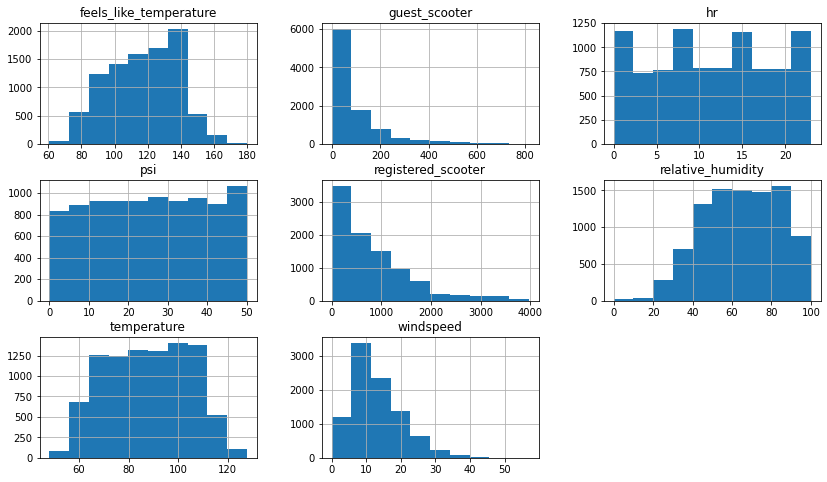

In [11]:
df.hist(figsize=(14,8))
plt.show()

## 3. One-Hot Encoding the Weather Column

In [12]:
ohe_weather = pd.get_dummies(df.weather)
new_df = pd.concat([df, ohe_weather], axis=1)
new_df.head()

,date,hr,weather,temperature,feels_like_temperature,relative_humidity,windspeed,psi,guest_scooter,registered_scooter,clear,cloudy,heavy snow/rain,light snow/rain
0,2011-12-22,10,cloudy,80.2,109.4,82.0,6.0,35,41,894,0,1,0,0
1,2011-02-25,11,clear,90.4,120.2,77.0,30.0,30,27,350,1,0,0,0
2,2011-06-19,5,cloudy,102.2,132.8,78.0,0.0,1,23,82,0,1,0,0
3,2011-07-01,17,clear,115.8,143.6,21.0,13.0,25,296,2533,1,0,0,0
4,2011-06-29,18,clear,114.1,143.6,29.0,20.0,6,236,3569,1,0,0,0
